This is the only cell you need to change (hopefully). Put in a list of the brain regions you want by acronym.

In [1]:
#do you want wildtype mice or cre mice? False = wildtype, True = transgenic mice, None = ALL MICE
cre_FT_input = False

#what hemisphere of the brain do you want? 1 = left hemisphere, 2 = right hemisphere, 3 = both
which_hemi = 3

#do you want to drop low values/exclude them from plots? 
#Type True if so
#False if no (meaning you want all values to be plotted even if they're TINY).
drop_lows = True

#if the above is False, this value below is ignored
#what bottom percent of values do you want to drop? for bottom 10% type 10, for 5% type 5, etc.
consider_zero = 10

#what top percent of values do you want to consider large? not too important but will produce slightly different visuals for last plot
#for top 20% type 20, etc.
consider_big = 10

Cell below imports all packages/libraries necessary to use the connectivity atlas and make plots

In [21]:
#will use networkx in later cells to look at connections
#you must install everything (allensdk was tricky for me) before running this 
#lots of this code is copied and/or modified from the allensdk mouse connectivity jupyter notebook example online or from pieter's prototypes
import pandas as pd 
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
import seaborn as sns
import networkx as nx
import itertools
import numpy
import matplotlib.pyplot as plt
import matplotlib as mpl
from allensdk.core.reference_space import ReferenceSpace
from allensdk.core.structure_tree import StructureTree
from allensdk.api.queries.ontologies_api import OntologiesApi
pd.set_option("display.max_rows", 50, "display.max_columns", 50)

In [22]:
node_input = ['ARH' ,'CB' ,'DMH' ,'MH', 'LH' ,'HIP' ,'ILA', 'PL', 'ORB' ,
              'CP' ,'GPe' ,'LHA' ,'MBO' ,'GPi' ,'MOB' ,'PVH' ,
              'LPO', 'MPO' ,'P' ,'SNr', 'SNc' ,'SCH' ,'SO' ,'TH' ,
              'VMH' ,'VISp',
              'LA','BLA','BMA','PA','sAMY']

The cell below downloads the allen atlas data, defines the structure tree class (useful), gives a list of all the experiments (we will use this later) and also a dictionary of the structure ids to the corresponding structure acronym.

In [23]:
# The manifest file is a simple JSON file that keeps track of all of
# the data that has already been downloaded onto the hard drives.
# If you supply a relative path, it is assumed to be relative to your
# current working directory.
mcc = MouseConnectivityCache(manifest_file='connectivity/mouse_connectivity_manifest.json')
# open up a list of all of the experiments
all_experiments = mcc.get_experiments(dataframe=True)
# grab the StructureTree instance (class?)
structure_tree = mcc.get_structure_tree()
#get the list of ids that correspond to acronyms
id_acronym = structure_tree.get_id_acronym_map()

The cell below imports and defines more things which are necessary to get the voxels of a structure (this is not in the connectivity atlas, but is in other Allen data, which is why many more things need to be imported).

In [24]:
import os
import nrrd
from allensdk.api.queries.ontologies_api import OntologiesApi
from allensdk.api.queries.mouse_connectivity_api import MouseConnectivityApi
from allensdk.config.manifest import Manifest
from allensdk.core.structure_tree import StructureTree
oapi = OntologiesApi()
structure_graph = oapi.get_structures_with_sets([1])  # 1 is the id of the adult mouse structure graph

# This removes some unused fields returned by the query
structure_graph = StructureTree.clean_structures(structure_graph)  

# the annotation download writes a file, so we will need somwhere to put it
annotation_dir = 'annotation'
Manifest.safe_mkdir(annotation_dir)
annotation_path = os.path.join(annotation_dir, 'annotation.nrrd')
# this is a string which contains the name of the latest ccf version
annotation_version = MouseConnectivityApi.CCF_VERSION_DEFAULT
mcapi = MouseConnectivityApi()
mcapi.download_annotation_volume(annotation_version, 25, annotation_path)
annotation, meta = nrrd.read(annotation_path)
tree = StructureTree(structure_graph)
from allensdk.core.reference_space import ReferenceSpace
# build a reference space from a StructureTree and annotation volume, the third argument is 
# the resolution of the space in microns
rsp = ReferenceSpace(tree, annotation, [25, 25, 25])

2023-04-25 11:41:16,063 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/annotation_25.nrrd


In [25]:
#save source volume in voxel to use later - want to account for volume of injection site
#below function will save the voxels of a structure
#input should be in quotes like so: 'CEA'
def get_voxels(brain_region):
    strucc_id = rsp.structure_tree.get_structures_by_acronym([brain_region])[0]['id']
    voxel = int(rsp.total_voxel_map[strucc_id])
    data1 = {'source':[brain_region],'voxels_of_injec_struc':[voxel]}
    voxels_and_node_name = pd.DataFrame(data=data1)
    return voxels_and_node_name

In [71]:
#use previously defined function to get voxel/volume table for all sources node/regions
source_voxels = pd.DataFrame()
for node1 in node_input:
    voxel1 = get_voxels(node1)
    source_voxels= pd.concat([source_voxels,voxel1])
#make ratio so numbers aren't crazy big
columnvoxels = source_voxels["voxels_of_injec_struc"]
max_value = columnvoxels.max()
source_voxels["voxels_of_injec_struc"] = source_voxels["voxels_of_injec_struc"]/max_value
print(source_voxels)

  source  voxels_of_injec_struc
0    ARH               0.005319
0     CB               1.000000
0    DMH               0.006986
0     MH               0.005948
0     LH               0.006425
0    HIP               0.440873
0    ILA               0.015664
0     PL               0.044738
0    ORB               0.109641
0     CP               0.483368
0    GPe               0.029060
0    LHA               0.038481
0    MBO               0.018877
0    GPi               0.007866
0    MOB               0.305842
0    PVH               0.003505
0    LPO               0.010310
0    MPO               0.010347
0      P               0.310387
0    SNr               0.028760
0    SNc               0.003666
0    SCH               0.001228
0     SO               0.000870
0     TH               0.376686
0    VMH               0.010208
0   VISp               0.131395
0     LA               0.015582
0    BLA               0.035301
0    BMA               0.027595
0     PA               0.017945
0   sAMY

In [72]:
#function to get list of injections from certain type of mouse, certain region of brain
#First argument is True or False and corresponds to whether you want wildtype (False) or transgenic(cre) mice (True)
#Second argument is the abbreviation of the brain region you want the injection site to be - make string in quotes
def get_injections(creFT, region):
    acronyms = structure_tree.get_structures_by_acronym([region])[0]
    df1 = mcc.get_experiments(cre=creFT, 
                                       injection_structure_ids=[acronyms['id']])
    return pd.DataFrame(df1)
#This is actually not used in this code at all but it is useful if you need to check things later so I will leave it

Below cell gets all experiment injection volume values, which we will need later to normalize data. id is renamed experiment_id because the name changes in the allensdk structuretree data instance

In [73]:
#grab only experiment volumes from all_experiments
all_exp_volumes=all_experiments[['id','injection_volume','injection_structures']]
#rename id experiment_id for later - we need this to normalize projection_density later
all_exp_volumes = all_exp_volumes.rename(columns={'id': 'experiment_id'})

Cell below is a function that grabs projection volume data, etc, given structures of interest (must input injection site and desired regions to which there are projections).

In [74]:
#source abbreviation and target abbreviation - put in quotes
#this is a function to get projection volumes by_acronym
#put in source and target and it will return the structure_unionizes data described here: 
#   https://alleninstitute.github.io/AllenSDK/unionizes.html
def sour_to_targ(source,target):
    targettab = structure_tree.get_structures_by_acronym([target])[0]
    sourcetab = structure_tree.get_structures_by_acronym([source])[0]
    sourcetab_experiments = mcc.get_experiments(cre=cre_FT_input, 
                                       injection_structure_ids=[sourcetab['id']])
    structure_unionizes = mcc.get_structure_unionizes([ e['id'] for e in sourcetab_experiments ], 
                                                  is_injection=False,
                                                  structure_ids=[targettab['id']],
                                                  include_descendants=True)
    structure_unionizes['source']=source
    return structure_unionizes
#if you get a "ValueError: No objects to concatenate" you can run this loop and find out which region is missing injections.
#for (i) in node_input:
#    print(get_injections(None,i))


In [75]:
node_entries = [structure_tree.get_structures_by_acronym([n])[0] for n in node_input]
node_ids = [n['id'] for n in node_entries]

In [76]:
sourcetab_experiments = mcc.get_experiments(cre=None
                                           )

In [77]:
structure_unionizes = mcc.get_structure_unionizes([ e['id'] for e in sourcetab_experiments ],
                                                  is_injection=False,
                                                  structure_ids=node_ids,
                                                  include_descendants=False,
                                                  hemisphere_ids=[3]
                                                 )

In [78]:
experiments_df = pd.DataFrame(sourcetab_experiments)
experiments_df

,gender,injection_structures,injection_volume,injection_x,injection_y,injection_z,product_id,specimen_name,strain,structure_abbrev,structure_id,structure_name,transgenic_line,transgenic_line_id,id,primary_injection_structure
0,F,"[502, 926, 1084, 484682470]",0.006655,9240,3070,8990,5,Penk-IRES2-Cre-neo-249961,C57BL/6J,SUB,502,Subiculum,Penk-IRES2-Cre-neo,298725927.0,527712447,502
1,M,"[574, 931]",0.105746,9170,6850,6200,5,Gabrr3-Cre_KC112-3467,C57BL/6J,PG,931,Pontine gray,Gabrr3-Cre_KC112,177838877.0,301875966,574
2,M,"[1, 210, 491, 525, 1004]",0.025762,7810,6550,6450,5,Hdc-Cre_IM1-204103,None,TMv,1,"Tuberomammillary nucleus, ventral part",Hdc-Cre_IM1,177839494.0,520336173,1
3,F,[304325711],0.013590,5580,7040,6270,31,Cdh4-Cre-215,None,retina,304325711,retina,Cdh4-CreER,308603472.0,307160976,304325711
4,F,[329],0.006724,6990,2150,2130,36,A930038C07Rik-Tg1-Cre-347488,None,SSp-bfd,329,"Primary somatosensory area, barrel field",A930038C07Rik-Tg1-Cre,177838542.0,644250774,329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2987,M,"[731, 746, 972]",0.282773,2350,3590,6020,5,378-1347,C57BL/6J,ORBm,731,"Orbital area, medial part",None,NaN,126860974,731
2988,M,[1039],0.004262,13090,5100,6030,5,378-1182,C57BL/6J,GR,1039,Gracile nucleus,None,NaN,114400640,1039
2989,M,"[337, 369]",0.428606,6350,1950,7740,5,378-1060,C57BL/6J,SSp-ll,337,"Primary somatosensory area, lower limb",None,NaN,112791318,337
2990,M,[385],0.031552,9340,1850,8290,5,Ntsr1-Cre-3502,C57BL/6J,VISp,385,Primary visual area,Ntsr1-Cre_GN220,177837713.0,156545918,385


In [79]:
region_exp_counts = {}
exp_dfs1 = {}
exp_dfs2 = {}
for i,n in enumerate(node_ids):
    #print(i)
    counts1 = [structure_tree.structure_descends_from(child_id=r['primary_injection_structure'],parent_id=n) 
               for j,r in experiments_df.iterrows()]
    exp_dfs1[n]=experiments_df.loc[counts1].copy()
    exp_dfs1[n].rename({'id':'experiment_id'},axis=1,inplace=True)
    counts1 = sum(counts1)

    counts2 = 0
    cond2s = []
    for j,r in experiments_df.iterrows():
        cond2 = [structure_tree.structure_descends_from(child_id=r,parent_id=n) for r in r['injection_structures']]
        cond2s = cond2s+[numpy.any(cond2)]
        counts2 = counts2 + numpy.any(cond2)
    exp_dfs2[n]=experiments_df.loc[cond2s].copy()
    exp_dfs2[n].rename({'id':'experiment_id'},axis=1,inplace=True)
    region_exp_counts[node_input[i]]={
        'id': n,
        'primary':counts1,
        'injection structure':counts2
    }

In [81]:
cond2 = [structure_tree.structure_descends_from(child_id=r,parent_id=n) for r in r['injection_structures']]
cond2s = cond2s+[numpy.any(cond2)]
counts2 = counts2 + numpy.any(cond2)

In [108]:
len(numpy.unique(exp_dfs2[549].experiment_id))

377

In [93]:
exp_dfs2[549].shape

(377, 16)

In [83]:
exp_counts_df = pd.DataFrame(region_exp_counts).transpose()

In [84]:
exp_counts_df

,id,primary,injection structure
ARH,223,10,52
CB,512,57,82
DMH,830,0,79
MH,483,0,24
LH,186,18,52
HIP,1080,113,200
ILA,44,33,48
PL,972,0,78
ORB,714,26,92
CP,672,42,113


(0.0, 400.0, 0.0, 20.0)

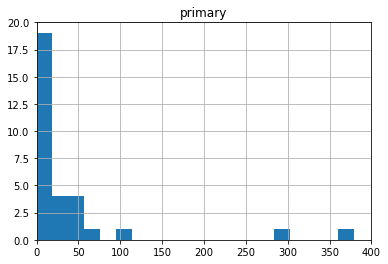

In [40]:
exp_counts_df['primary'].hist(bins=20)
limits = [0,400,0,20]
plt.title('primary')
plt.axis(limits)

(0.0, 400.0, 0.0, 20.0)

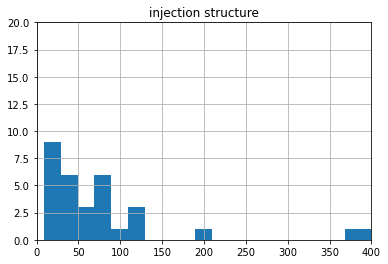

In [41]:
exp_counts_df['injection structure'].hist(bins=20)
plt.title('injection structure')
plt.axis(limits)

In [42]:
pd.set_option('display.max_rows',100)

In [43]:
exp_counts_df.loc[exp_counts_df['primary'] < 5]

,id,primary,injection structure
DMH,830,0,79
MH,483,0,24
PL,972,0,78
GPe,1022,2,40
GPi,1031,0,33
MPO,523,0,47
SNr,381,0,18
SNc,374,3,19
SCH,286,0,9
VMH,693,1,72


In [44]:
exp_counts_df.loc[exp_counts_df['injection structure'] < 5]

,id,primary,injection structure


In [132]:
t_df = structure_unionizes.merge(exp_dfs1[549][['experiment_id','primary_injection_structure']],
                                         how='inner',left_on='experiment_id',right_on='experiment_id')

In [133]:
for i in [183225830, 174957972, 263785543]:
    if i in t_df.experiment_id.values:
        print(i)

183225830
174957972


In [129]:
for i in [183225830, 174957972, 263785543]:
    if i in structure_unionizes.experiment_id:
        print(i)

In [117]:
527712447 in structure_unionizes.experiment_id.values

True

In [137]:
t_df.loc[~t_df.experiment_id.isin([183225830, 174957972, 263785543])]

,experiment_id,hemisphere_id,id,is_injection,max_voxel_density,max_voxel_x,max_voxel_y,max_voxel_z,normalized_projection_volume,projection_density,projection_energy,projection_intensity,projection_volume,structure_id,sum_pixel_intensity,sum_pixels,sum_projection_pixel_intensity,sum_projection_pixels,volume,primary_injection_structure
0,578332611,3,636574313,False,0.000000,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,693,1.906924e+11,4.945086e+08,0.000000e+00,0.000000e+00,0.605773,15
1,578332611,3,636574186,False,0.340475,1900,3040,4510,0.002278,0.000008,0.008331,1093.868123,0.000138,507,5.775665e+12,1.481787e+10,1.234542e+08,1.128602e+05,18.151891,15
2,578332611,3,636573928,False,0.520213,6610,5280,2340,0.003511,0.000230,0.411549,1788.745202,0.000213,131,3.233453e+11,7.562592e+08,3.112379e+08,1.739979e+05,0.926418,15
3,578332611,3,636573868,False,0.000000,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,38,5.985033e+10,1.698750e+08,0.000000e+00,0.000000e+00,0.208097,15
4,578332611,3,636574120,False,0.369357,9780,910,3230,0.006902,0.000054,0.048417,901.384555,0.000419,385,2.755194e+12,6.366721e+09,3.082605e+08,3.419856e+05,7.799233,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9140,147212977,3,633946625,False,0.371000,7020,5510,8110,0.007561,0.000255,0.128975,505.135946,0.001139,278,8.146988e+11,3.642862e+09,4.698373e+08,9.301205e+05,4.462505,27
9141,147212977,3,633945748,False,0.715391,6690,3020,8970,0.097825,0.000514,0.365048,710.311819,0.014742,672,5.505084e+12,2.341689e+10,8.548296e+09,1.203457e+07,28.685694,27
9142,147212977,3,633945577,False,0.322872,4870,6610,6090,0.001548,0.000381,0.221042,580.444955,0.000233,523,1.283225e+11,4.999770e+08,1.105157e+08,1.903983e+05,0.612472,27
9143,147212977,3,633945605,False,1.000000,8130,4300,7830,6.597217,0.044692,78.811077,1763.409716,0.994210,549,4.827561e+12,1.815968e+10,1.431184e+12,8.116004e+08,22.245609,27


In [150]:
all_proj_vols = pd.DataFrame()
all_prof_vols_dict = {}
edge_region_exp_counts = {}
for i,n1 in enumerate(node_ids):
    print(i)
    edge_region_exp_counts[node_input[i]] = {}
    if (exp_dfs2[n1].shape[0]==0):
        continue
    if (n1==549):
        t_df = structure_unionizes.merge(exp_dfs1[n1][['experiment_id','primary_injection_structure']],
                                         how='inner',left_on='experiment_id',right_on='experiment_id')
        t_df = t_df.loc[~t_df.experiment_id.isin([183225830, 174957972, 263785543])]
        print('done')
    else:
        t_df = structure_unionizes.merge(exp_dfs2[n1][['experiment_id','primary_injection_structure','injection_structures']],
                                         how='inner',left_on='experiment_id',right_on='experiment_id')
    #t_df = structure_unionizes.merge(exp_dfs1[n1][['experiment_id','primary_injection_structure']],
    #                                 how='inner',left_on='experiment_id',right_on='experiment_id')
    t_df['source'] = node_input[i]
    for j,n2 in enumerate(node_ids):
        counts = t_df['structure_id'].value_counts()[n2]
        edge_region_exp_counts[node_input[i]][node_input[j]] = counts
        
        t2_df = t_df.loc[t_df['structure_id']==n2]
        all_prof_vols_dict[f'{n1}{n2}']=t2_df.copy()
all_proj_vols = pd.concat([all_prof_vols_dict[k] for k in all_prof_vols_dict.keys()])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
done
24
25
26
27
28
29
30


/home/kbeier/anaconda2/envs/projections/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [154]:
pd.DataFrame(edge_region_exp_counts)

,ARH,CB,DMH,MH,LH,HIP,ILA,PL,ORB,CP,GPe,LHA,MBO,GPi,MOB,PVH,LPO,MPO,P,SNr,SNc,SCH,SO,TH,VMH,VISp,LA,BLA,BMA,PA,sAMY
ARH,52,82,79,24,52,200,48,78,92,113,40,109,75,33,26,49,34,47,125,18,19,9,13,293,72,409,14,25,43,24,81
CB,52,82,79,24,52,200,48,78,92,113,40,109,75,33,26,49,34,47,125,18,19,9,13,293,72,409,14,25,43,24,81
DMH,52,82,79,24,52,200,48,78,92,113,40,109,75,33,26,49,34,47,125,18,19,9,13,293,72,409,14,25,43,24,81
MH,52,82,79,24,52,200,48,78,92,113,40,109,75,33,26,49,34,47,125,18,19,9,13,293,72,409,14,25,43,24,81
LH,52,82,79,24,52,200,48,78,92,113,40,109,75,33,26,49,34,47,125,18,19,9,13,293,72,409,14,25,43,24,81
HIP,52,82,79,24,52,200,48,78,92,113,40,109,75,33,26,49,34,47,125,18,19,9,13,293,72,409,14,25,43,24,81
ILA,52,82,79,24,52,200,48,78,92,113,40,109,75,33,26,49,34,47,125,18,19,9,13,293,72,409,14,25,43,24,81
PL,52,82,79,24,52,200,48,78,92,113,40,109,75,33,26,49,34,47,125,18,19,9,13,293,72,409,14,25,43,24,81
ORB,52,82,79,24,52,200,48,78,92,113,40,109,75,33,26,49,34,47,125,18,19,9,13,293,72,409,14,25,43,24,81
CP,52,82,79,24,52,200,48,78,92,113,40,109,75,33,26,49,34,47,125,18,19,9,13,293,72,409,14,25,43,24,81


In [50]:
#dict_exp_to_include = {'SH': [300841699], 'PAA': [122641078, 113935990], 'FC': [301122593], 'ASO': [267540168, 264319363, 308641549], 'BAC': [287246555], 'FS': [175372863, 113505468], 'SAG': [114474520, 174583187], 'RPO': [168515225], 'SCH': [287246555], 'NB': [114474520, 174583187], 'SPA': [263785543], 'RR': [171021829], 'OT': [293008559], 'MEPO': [303580293], 'SLD': [480689656], 'TT': [114755099], 'AUDv': [112881858], 'DP': [133286030], 'EW': [543880631], 'SNr': [174788109, 160539283], 'PVpo': [293549729, 119846838], 'CS': [300689439, 299761999], 'PERI': [127397469], 'SF': [100141597], 'MA': [147632458], 'MH': [267959197], 'PA': [129573239, 304721447, 115958115], 'NDB': [113553300, 177605425], 'POST': [294397907, 264873092], 'SCs': [182029881, 128001349], 'MS': [168094300, 113696423], 'VISC': [113036264], 'VPL': [268399868, 171065200], 'RN': [175018829, 174583904], 'PRE': [287770700, 127222723], 'AUDpo': [120437703, 158314278], 'GU': [299783689, 180982124, 180917660], 'GPi': [265944167], 'COA': [114249084, 305124396], 'DR': [287247978, 266500714], 'CLA': [180436360, 267762146], 'MPN': [181057754, 523705737], 'GPe': [304970618], 'SUM': [293255030], 'VTA': [180522266], 'AUDd': [266963362, 182090318], 'CEA': [113935990, 146795148], 'PALm': [176886238], 'BST': [267763584], 'PL': [294434161], 'ILM': [263785543, 299732738], 'DMS': [127762867, 148198052, 146553266, 100142580, 112458831, 124059700, 160537796, 160537018, 159223001], 'DLS': [117317884, 113766038, 114399934, 113505468, 127711803, 175072215, 112307754, 158916311, 120570964, 159941339]}

In [51]:
#more_proj_vols = {}
#for r in dict_exp_to_include.keys():
#    more_proj_vols[r] = mcc.get_structure_unionizes(experiment_ids =dict_exp_to_include[r], is_injection=False,
#structure_ids=None, hemisphere_ids=[3])
#    more_proj_vols[r]['source'] = r
#more_proj_vols_df = pd.concat([more_proj_vols[r] for r in more_proj_vols.keys()])

In [52]:
#all_proj_vols = pd.concat([all_proj_vols,more_proj_vols_df])

In [155]:
all_proj_vols = all_proj_vols.reset_index(drop=True)

In [156]:
#make a projection volume file to save our future selves from having to download the whole brain next time        
all_proj_vols.to_csv('data/bab-proj-vols-primary.20230429.csv')

In [157]:
#load the projection volume file from the Pipeline-Variations dir
all_proj_vols=pd.read_csv('data/bab-proj-vols-primary.20230429.csv', index_col=0)
#this cell specifies which hemisphere of the brain we care about (right, left, or both)
specify_hemisphere = all_proj_vols.copy()

Below cell deletes data where targets are irrelevant structures, and replaces the number id with the acronym. Python doesn't like that I'm replacing data with new values so it gives me a warning but just ignore it huhu.

In [158]:
select_proj_vols = pd.DataFrame()
for node1 in node_input:
    num_id = id_acronym[node1]
    target1 = specify_hemisphere.loc[specify_hemisphere['structure_id'] == num_id]
    target1['target'] = target1['structure_id'].replace(num_id,node1)
    select_proj_vols= pd.concat([select_proj_vols,target1])

/home/kbeier/anaconda2/envs/projections/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [159]:
#elimate node -> same node projections
#there might be a better way to do this but uh this works
comparison_column = numpy.where(select_proj_vols["source"] == select_proj_vols["target"], True, False)
select_proj_vols["equal"] = comparison_column
select_proj_vols = select_proj_vols[select_proj_vols.equal != True]

In [160]:
select_proj_vols.head()

,experiment_id,hemisphere_id,id,injection_structures,is_injection,max_voxel_density,max_voxel_x,max_voxel_y,max_voxel_z,normalized_projection_volume,primary_injection_structure,projection_density,projection_energy,projection_intensity,projection_volume,source,structure_id,sum_pixel_intensity,sum_pixels,sum_projection_pixel_intensity,sum_projection_pixels,volume,target,equal
1612,287664997,3,632222921,"[91, 96, 217, 781, 846, 1007, 1033, 1041, 1049]",False,0.014379,6540,6950,5670,0.000004,91,9.944142e-07,0.000249,250.142845,3.123872e-07,CB,223,2.473334e+09,256442400.0,6.378892e+04,255.009964,0.314142,ARH,False
1613,168230532,3,629768996,[1017],False,0.042661,6790,7110,6020,0.000065,1017,3.521013e-05,0.006688,189.957107,1.106098e-05,CB,223,1.471937e+10,256442400.0,1.715193e+06,9029.371460,0.314142,ARH,False
1614,168664192,3,629895943,"[91, 217, 372, 867, 920, 928, 589508455]",False,0.063806,6540,6940,5720,0.000050,91,1.001490e-05,0.004293,428.616481,3.146102e-06,CB,223,5.455899e+10,256442400.0,1.100793e+06,2568.246216,0.314142,ARH,False
1615,552283801,3,635881060,"[96, 846, 1007, 1017, 1033, 1041]",False,0.000000,0,0,0,0.000000,96,0.000000e+00,0.000000,0.000000,0.000000e+00,CB,223,7.783875e+10,256442400.0,0.000000e+00,0.000000,0.314142,ARH,False
1616,304474221,3,635857842,"[91, 217, 372, 968, 989, 589508455]",False,0.000000,0,0,0,0.000000,91,0.000000e+00,0.000000,0.000000,0.000000e+00,CB,223,5.929788e+10,256442400.0,0.000000e+00,0.000000,0.314142,ARH,False


In [161]:
all_exp_volumes[['experiment_id','injection_volume']].head()

,experiment_id,injection_volume
id,,
527712447,527712447,0.006655
301875966,301875966,0.105746
520336173,520336173,0.025762
307160976,307160976,0.013590
644250774,644250774,0.006724


In [162]:
#get injection volume for each brain and add it to the main dataframe we're workin with
cols = ['experiment_id']
calc_proj_dens =select_proj_vols.join(all_exp_volumes[['injection_volume']], on=cols)
#create normalized projection density by dividing projection density/injection volume
#I think this value makes the most sense for weights...
calc_proj_dens['normalized_projection_density']=calc_proj_dens['projection_density']/calc_proj_dens['injection_volume']

In [163]:
#get source_voxels for each region (did earlier) and add it to the main dataframe we're workin with
cols2 = ['source']
calc_proj_dens2 =calc_proj_dens.join(source_voxels.set_index(cols2), on=cols2)
#create normalized projection density by structure by dividing normalized projection density/source voxels
#this is a testt huhuhhu
calc_proj_dens2['normalized_projection_density_plus_sourceVOL']=calc_proj_dens2['normalized_projection_density']*calc_proj_dens2['voxels_of_injec_struc']
calc_proj_dens2.head()

,experiment_id,hemisphere_id,id,injection_structures,is_injection,max_voxel_density,max_voxel_x,max_voxel_y,max_voxel_z,normalized_projection_volume,primary_injection_structure,projection_density,projection_energy,projection_intensity,projection_volume,source,structure_id,sum_pixel_intensity,sum_pixels,sum_projection_pixel_intensity,sum_projection_pixels,volume,target,equal,injection_volume,normalized_projection_density,voxels_of_injec_struc,normalized_projection_density_plus_sourceVOL
1612,287664997,3,632222921,"[91, 96, 217, 781, 846, 1007, 1033, 1041, 1049]",False,0.014379,6540,6950,5670,0.000004,91,9.944142e-07,0.000249,250.142845,3.123872e-07,CB,223,2.473334e+09,256442400.0,6.378892e+04,255.009964,0.314142,ARH,False,0.083751,0.000012,1.0,0.000012
1613,168230532,3,629768996,[1017],False,0.042661,6790,7110,6020,0.000065,1017,3.521013e-05,0.006688,189.957107,1.106098e-05,CB,223,1.471937e+10,256442400.0,1.715193e+06,9029.371460,0.314142,ARH,False,0.169229,0.000208,1.0,0.000208
1614,168664192,3,629895943,"[91, 217, 372, 867, 920, 928, 589508455]",False,0.063806,6540,6940,5720,0.000050,91,1.001490e-05,0.004293,428.616481,3.146102e-06,CB,223,5.455899e+10,256442400.0,1.100793e+06,2568.246216,0.314142,ARH,False,0.062617,0.000160,1.0,0.000160
1615,552283801,3,635881060,"[96, 846, 1007, 1017, 1033, 1041]",False,0.000000,0,0,0,0.000000,96,0.000000e+00,0.000000,0.000000,0.000000e+00,CB,223,7.783875e+10,256442400.0,0.000000e+00,0.000000,0.314142,ARH,False,0.006459,0.000000,1.0,0.000000
1616,304474221,3,635857842,"[91, 217, 372, 968, 989, 589508455]",False,0.000000,0,0,0,0.000000,91,0.000000e+00,0.000000,0.000000,0.000000e+00,CB,223,5.929788e+10,256442400.0,0.000000e+00,0.000000,0.314142,ARH,False,0.261310,0.000000,1.0,0.000000


The data in the table below is all of the data that will be used for figures later (all plots and heatmaps). If your plots or heatmaps look wrong check to see that this table makes sense. You may also want to look at the top of the table and see if there are any crazy outliers.

In [164]:
#sort data from largest normalized_projection_density to lowest
calc_proj_dens_sorted=calc_proj_dens2.sort_values(axis=0,by='normalized_projection_density_plus_sourceVOL',ascending=False)
#view all your data
#pd.set_option("display.max_rows", None, "display.max_columns", None)
calc_proj_dens_sorted.head()

,experiment_id,hemisphere_id,id,injection_structures,is_injection,max_voxel_density,max_voxel_x,max_voxel_y,max_voxel_z,normalized_projection_volume,primary_injection_structure,projection_density,projection_energy,projection_intensity,projection_volume,source,structure_id,sum_pixel_intensity,sum_pixels,sum_projection_pixel_intensity,sum_projection_pixels,volume,target,equal,injection_volume,normalized_projection_density,voxels_of_injec_struc,normalized_projection_density_plus_sourceVOL
9869,510125001,3,634736305,"[186, 362, 483, 575, 726]",False,0.815843,7050,3140,6120,1.256902,186,0.015086,14.382429,953.374539,0.005542,HIP,186,7.739541e+10,2.998980e+08,4.313262e+09,4.524205e+06,0.367375,LH,False,0.004409,3.421304,0.440873,1.508360
45949,528732005,3,640918141,NaN,False,0.548732,3780,3390,5630,3.667864,181,0.013049,9.137015,700.210532,0.012147,TH,44,1.917271e+11,7.598898e+08,6.943124e+09,9.915767e+06,0.930865,ILA,False,0.003312,3.940276,0.376686,1.484248
45886,609475139,3,641556641,NaN,False,0.529996,3470,3860,5660,3.230571,149,0.006314,5.679180,899.435121,0.005878,TH,44,2.197107e+11,7.598898e+08,4.315551e+09,4.798068e+06,0.930865,ILA,False,0.001819,3.470505,0.376686,1.307292
45268,510125001,3,634736305,NaN,False,0.815843,7050,3140,6120,1.256902,186,0.015086,14.382429,953.374539,0.005542,TH,186,7.739541e+10,2.998980e+08,4.313262e+09,4.524205e+06,0.367375,LH,False,0.004409,3.421304,0.376686,1.288759
46163,592698087,3,641401070,NaN,False,0.657811,3730,3290,4830,7.389369,127,0.005624,5.454861,969.928838,0.014946,TH,972,4.988392e+11,2.169358e+09,1.183355e+10,1.220043e+07,2.657464,PL,False,0.002023,2.780610,0.376686,1.047418


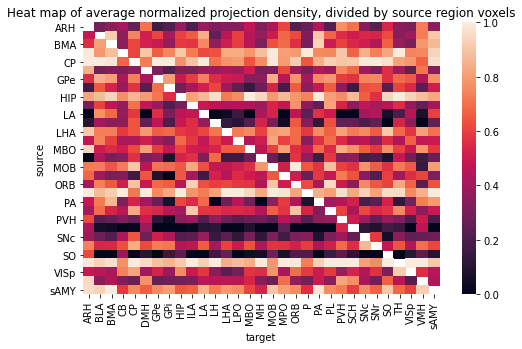

In [165]:
f = plt.figure(figsize=(8,5))
p = calc_proj_dens_sorted.pivot_table(index='source', columns='target', values='normalized_projection_density_plus_sourceVOL', aggfunc=numpy.mean)
logp = numpy.log(p)
logzerop = logp - numpy.min(logp)
lognormp = logzerop / numpy.max(logzerop)
#lognormp = (numpy.log(p)-numpy.min(p))/numpy.max(numpy.log(p)-numpy.min(p))
ax3 = sns.heatmap(lognormp)
plt.title('Heat map of average normalized projection density, divided by source region voxels')
plt.show()

Above is a heatmap of all data that will be used for the connectivity plots later. The heat map and plots below should match/look similar! If they don't match, something went wrong.

In [166]:
#make a dataframe of node to same node projection which we will make zero for all
self_zero_data = pd.DataFrame()
for node1 in node_input:
    new_self_df = {'source':[node1], 'target' :[node1], 'normalized_projection_density_source_average':[0]}
    self_zero_df = pd.DataFrame(new_self_df) 
    self_zero_data= pd.concat([self_zero_data,self_zero_df])

In [167]:
#get averages for each source to target relationship
grouped_multiple = calc_proj_dens_sorted.groupby(['source', 'target']).agg({'normalized_projection_density_plus_sourceVOL': ['mean']})
grouped_multiple.columns = ['normalized_projection_density_source_average']
grouped_multiple = grouped_multiple.reset_index()

In [168]:
#combine the source to target and the source to self average dataframes
ALLnormdensity_averages = pd.concat([grouped_multiple,self_zero_data])
#ALLnormdensity_averages = ALLnormdensity_averages.loc[~ALLnormdensity_averages.source.isin(exclude_regions) & 
#                                                      ~ALLnormdensity_averages.target.isin(exclude_regions)]
ALLnormdensity_averages.reset_index(drop=True,inplace=True)

In [169]:
ALLnormdensity_averages.source.value_counts(ascending=True)[:20]

VISp    31
SNr     31
ARH     31
LA      31
BLA     31
VMH     31
PVH     31
PA      31
PL      31
LHA     31
P       31
BMA     31
SNc     31
MPO     31
CB      31
CP      31
LPO     31
SO      31
HIP     31
MOB     31
Name: source, dtype: int64

In [170]:
len(ALLnormdensity_averages.source.unique())

31

In [171]:
print(list(set(node_input)-set(ALLnormdensity_averages.source.unique())))

[]


In [172]:
ALLnormdensity_averages.to_csv('data/ALLnormdensity_averages-primary.bab-20230429.csv')

In [26]:
#copy of pieter's code. defines nodes of graphs (will be displayed as acronyms).
G = nx.DiGraph()
#below define nodes from source
nodes=node_input
idx=list(range(0,len(nodes)))

#G.add_nodes_from(idx)
G.add_nodes_from(nodes)

#adds edges to G from the average normalized projection densities for each source -> target relationship
for (x,y) in itertools.product(node_input,node_input):
    query_df = ALLnormdensity_averages.copy()
    query_df = query_df.loc[(query_df.source == x) & (query_df.target ==y)]
    if query_df.shape[0] == 0:
        continue
    weight = query_df.normalized_projection_density_source_average.iloc[0]
    G.add_edge(x,y,weight=weight)

In [27]:
#remove edges if their weight is exactly zero (these are placeholder zeros that I put in. Data from allen won't be zero.)
ALLnormdensity_averages = ALLnormdensity_averages[ALLnormdensity_averages.normalized_projection_density_source_average != 0.0]
edge_weights = nx.get_edge_attributes(G,'weight')
if drop_lows == True:
    G.remove_edges_from((e for e, w in edge_weights.items() if w == 0.0))

Checkpoint - I feel good about the code above so far being able to handle multiple different nodes/lengths. Everything below is a WIP but still works - large and zero/small values need to be changed for each case but this pipeline works with modifications I think.

In [28]:
consider_big = 1
consider_zero = 95

#establish what large and zero are
large=numpy.percentile(ALLnormdensity_averages['normalized_projection_density_source_average'], 100-consider_big) 
#changed zero to 0.01 from 0.1
zero=numpy.percentile(ALLnormdensity_averages['normalized_projection_density_source_average'], consider_zero) 
print('large is over '+str(large))
print('zero is below '+str(zero))

large is over 0.026515232250925346
zero is below 0.007649838590880898


In [29]:
#copy of pieter's prototype code
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > large]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if (d['weight'] <= large) & (d['weight'] > zero)]
ezero = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] <= zero]

In [30]:
#copy of pieter's prototype code
enonzero = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > zero]
weights=[d['weight'] for (u, v, d) in G.edges(data=True) if d['weight'] > zero]
print(len(elarge))
print(len(esmall))
print(len(ezero))

182
724
17207


In [31]:
#copy of pieter's prototype code
max_weight=numpy.max(weights)

edge_colors = [w/max_weight for w in weights]
edge_alphas = [w/max_weight for w in weights]

len(weights)

906

The cell below is only executed if drop_lows is defined as True in the first cell. If it is False, no values will be dropped.

In [168]:
#remove edges if their weight is in the specified bottom percentiles
edge_weights = nx.get_edge_attributes(G,'weight')
if drop_lows == True:
    G.remove_edges_from((e for e, w in edge_weights.items() if w < zero))

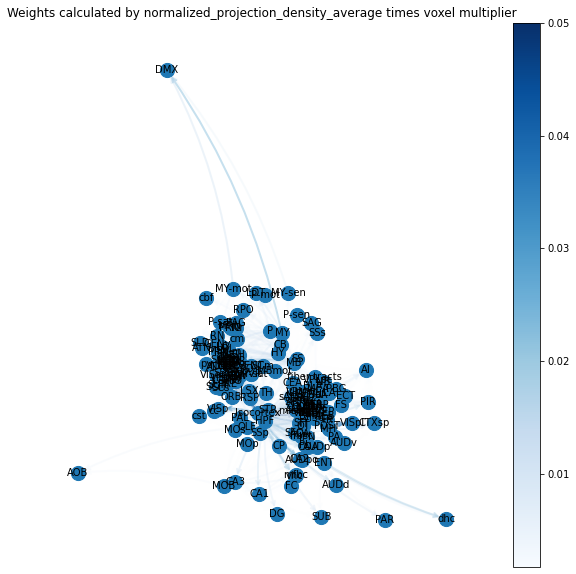

In [172]:
#copy of pieter's prototype code
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(10,10))
# nodes
nx.draw_networkx_nodes(G, pos, node_size=200)
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif');

edges=nx.draw_networkx_edges(G, pos, node_size=200, edgelist=enonzero,
                             arrowstyle='->', arrowsize=10, width=2,
                               connectionstyle='arc3, rad=0.1',
                             edge_color=weights, edge_cmap=plt.cm.Blues)

for i in range(len(edges)):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(weights)
plt.colorbar(pc)

plt.title('Weights calculated by normalized_projection_density_average times voxel multiplier')
ax = plt.gca()
ax.set_axis_off()
plt.savefig("figures/allnodes-spring_layout_edges.svg")
plt.show()

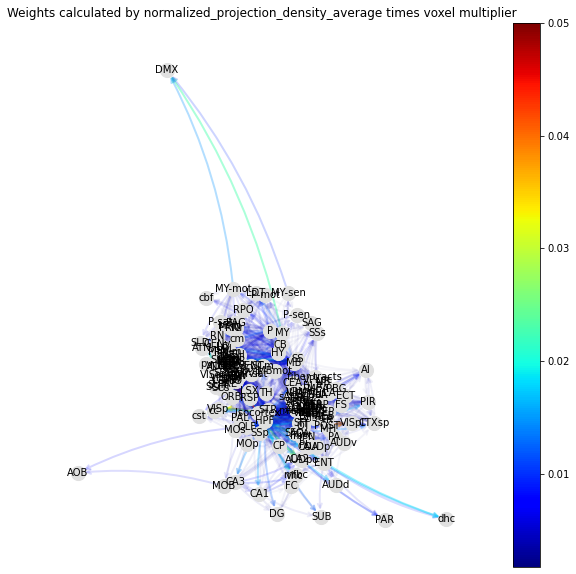

In [175]:
#copy of pieter's prototype code
zero=zero

enonzero = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > zero]
weights=[d['weight'] for (u, v, d) in G.edges(data=True) if d['weight'] > zero]

max_weight=numpy.max(weights)

edge_colors = [w/max_weight for w in weights]
edge_alphas = [w/max_weight for w in weights]

len(weights)

pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(10,10))

# nodes
nx.draw_networkx_nodes(G, pos, node_size=200,node_color='#E0E0E0')
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

edges=nx.draw_networkx_edges(G, pos, node_size=200, edgelist=enonzero,
                             arrowstyle='->', arrowsize=10, width=2,
                               connectionstyle='arc3, rad=0.1',
                             edge_color=weights, edge_cmap=plt.cm.jet)

for i in range(len(edges)):
    edges[i].set_alpha(edge_alphas[i])
    
pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.jet)
pc.set_array(weights)
plt.colorbar(pc)

plt.title('Weights calculated by normalized_projection_density_average times voxel multiplier')
ax = plt.gca()
ax.set_axis_off()
plt.savefig('figures/all_1.svg')
plt.show()

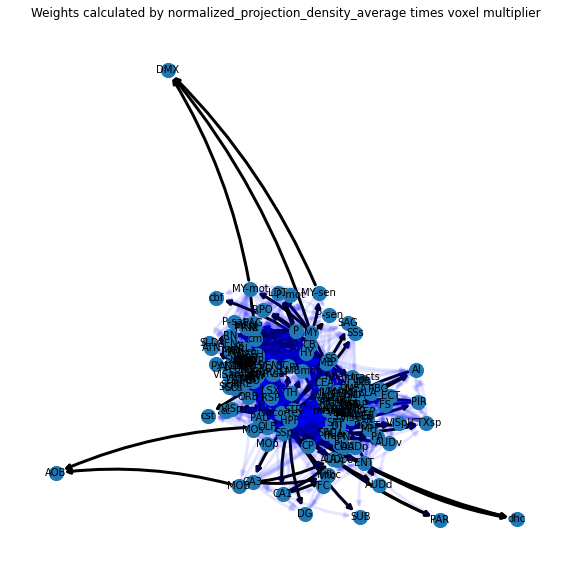

In [176]:
#copy of pieter's prototype code
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(10,10))
# nodes
nx.draw_networkx_nodes(G, pos, node_size=200)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge,
                       width=3, connectionstyle='arc3, rad=0.1')
nx.draw_networkx_edges(G, pos, edgelist=esmall,
                       width=3, alpha=0.1, edge_color='b',
                      connectionstyle='arc3, rad=0.1')

nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.title('Weights calculated by normalized_projection_density_average times voxel multiplier')
plt.axis('off')
plt.savefig('figures/all_2.svg')
plt.show()

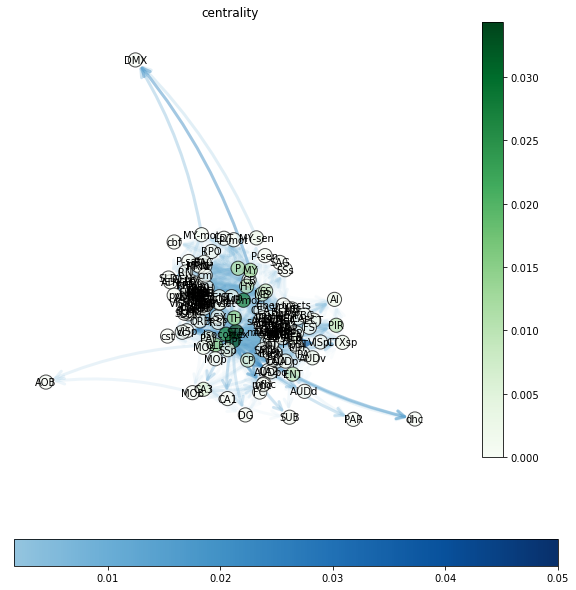

In [177]:
#nodes colored by centrality
#copy of pieter's prototype code
import matplotlib.colors as colors
#node_cen=nx.degree_centrality(G, k=None, normalized=True, weight='weight')
node_cen=nx.betweenness_centrality(G, k=None, normalized=True, weight='weight')
cen_scores=[]
for node in node_input:
    cen_scores.append(node_cen[node])
# draw the graph
pos = nx.kamada_kawai_layout(G) # nx.spring_layout(G)
# color the nodes according to their partition
cmap = plt.cm.get_cmap('Greens')
#norm = colors.Normalize(vmin=min(btw_scores),vmax=max(btw_scores))
# edges
plt.figure(figsize=(10,10))
nodes = nx.draw_networkx_nodes(G, pos, node_size=200,
                       cmap=cmap, alpha=0.7,node_color=cen_scores)
enonzero = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > zero]
weights=[d['weight'] for (u, v, d) in G.edges(data=True) if d['weight'] > zero]
max_weight=numpy.max(weights)
edge_colors = [w/max_weight for w in weights]
edge_alphas = [w/max_weight for w in weights]
edge_cmap=plt.cm.Blues
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(numpy.linspace(minval, maxval, n)))
    return new_cmap
edge_cmap=truncate_colormap(edge_cmap, 0.4, 1)
edges=nx.draw_networkx_edges(G, pos, node_size=200, edgelist=enonzero,
                             arrowstyle='->', arrowsize=20, width=3,
                               connectionstyle='arc3, rad=0.1',
                             edge_color=weights, edge_cmap=edge_cmap)
for i in range(len(edges)):
    edges[i].set_alpha(edge_alphas[i])
pc = mpl.collections.PatchCollection(edges, cmap=edge_cmap)
pc.set_array(weights)
plt.colorbar(pc, orientation="horizontal", fraction=0.05)
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min(cen_scores), vmax=max(cen_scores)))
plt.colorbar(sm)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
plt.axis('off')
plt.title('centrality')
plt.savefig('figures/all_3.svg')
plt.show()

Centrality Analysis with networkx:

In [130]:
nx.degree_centrality(G)
#will be all the same if drop_lows is False

{'AOB': 0.017857142857142856,
 'ASO': 0.047619047619047616,
 'AI': 0.11309523809523808,
 'AAA': 0.05357142857142857,
 'ACA': 0.05357142857142857,
 'ATN': 0.03571428571428571,
 'AHN': 0.05357142857142857,
 'ADP': 0.047619047619047616,
 'VISal': 0.047619047619047616,
 'VISam': 0.047619047619047616,
 'ARH': 0.023809523809523808,
 'BLA': 0.07738095238095238,
 'BMA': 0.05952380952380952,
 'BST': 0.07142857142857142,
 'BAC': 0.07738095238095238,
 'CP': 0.22619047619047616,
 'CEA': 0.09523809523809523,
 'CLI': 0.08333333333333333,
 'CB': 0.22619047619047616,
 'CLA': 0.10714285714285714,
 'COA': 0.06547619047619047,
 'CTXsp': 0.17857142857142855,
 'DG': 0.06547619047619047,
 'NDB': 0.06547619047619047,
 'AUDd': 0.03571428571428571,
 'DMX': 0.023809523809523808,
 'DR': 0.07142857142857142,
 'DP': 0.05357142857142857,
 'ECT': 0.09523809523809523,
 'EW': 0.07142857142857142,
 'EP': 0.06547619047619047,
 'ENT': 0.19642857142857142,
 'FC': 0.017857142857142856,
 'CA1': 0.08333333333333333,
 'CA2': 

In [36]:
nx.closeness_centrality(G, u=None, distance='weight', wf_improved=True)

{'ACA': 4050.7940668276874,
 'BLA': 4010.889892636082,
 'CA1': 4534.752268297516,
 'CA3': 4743.527812469259,
 'CEA': 3679.5178425460313,
 'CP': 3501.1133604149777,
 'DG': 4510.228298646488,
 'GPe': 4520.102125312939,
 'LA': 4481.553873724201,
 'PL': 3845.7885249760834,
 'TH': 3170.5583178255233,
 'VPM': 3745.598572097608,
 'AI': 3671.811742999427,
 'CB': 5223.453690833767,
 'ENT': 4249.621597738565,
 'HY': 3776.960437668717,
 'MOp': 4510.067255948261,
 'OLF': 3347.829587493924,
 'PIR': 3822.11904664288,
 'SSp': 4551.109921820286,
 'SSs': 4112.307273019353,
 'VISp': 3643.101308536699,
 'BST': 3784.018913616112,
 'MH': 3700.353261065936,
 'ACB': 3887.5019365081534,
 'ORB': 4337.664355735127,
 'VTA': 4663.672917302781,
 'LH': 3589.604008981943}

In [37]:
nx.eigenvector_centrality_numpy(G, weight='weight')

{'ACA': 0.1066588176334782,
 'BLA': 0.4159112875161287,
 'CA1': 0.10080178701050416,
 'CA3': 0.04077055295290513,
 'CEA': 0.2760556364663486,
 'CP': 0.18228504923779815,
 'DG': 0.07180808624116765,
 'GPe': 0.14792733395506952,
 'LA': 0.29342961734800604,
 'PL': 0.1980005332849647,
 'TH': 0.0797619469508269,
 'VPM': 0.08250691577054506,
 'AI': 0.3124288214697848,
 'CB': 0.005677750289599006,
 'ENT': 0.20550694797722252,
 'HY': 0.07856848917053938,
 'MOp': 0.07481179166569306,
 'OLF': 0.1918595269038969,
 'PIR': 0.3551682947792731,
 'SSp': 0.06245752007220981,
 'SSs': 0.08077374482452021,
 'VISp': 0.05522506777831196,
 'BST': 0.21107500692474632,
 'MH': 0.041778647265301914,
 'ACB': 0.32640121474373796,
 'ORB': 0.18888402181649364,
 'VTA': 0.08300981034200794,
 'LH': 0.07341772348147364}

In [38]:
nx.betweenness_centrality(G, k=None, normalized=True, weight='weight')

{'ACA': 0.017094017094017096,
 'BLA': 0.042735042735042736,
 'CA1': 0.09971509971509972,
 'CA3': 0.14387464387464388,
 'CEA': 0.03418803418803419,
 'CP': 0.0,
 'DG': 0.06695156695156695,
 'GPe': 0.05128205128205129,
 'LA': 0.12108262108262109,
 'PL': 0.03703703703703704,
 'TH': 0.0,
 'VPM': 0.12393162393162394,
 'AI': 0.008547008547008548,
 'CB': 0.1851851851851852,
 'ENT': 0.0,
 'HY': 0.0,
 'MOp': 0.019943019943019943,
 'OLF': 0.004273504273504274,
 'PIR': 0.0,
 'SSp': 0.0,
 'SSs': 0.021367521367521368,
 'VISp': 0.0,
 'BST': 0.10541310541310542,
 'MH': 0.045584045584045586,
 'ACB': 0.01851851851851852,
 'ORB': 0.07264957264957266,
 'VTA': 0.19230769230769232,
 'LH': 0.07407407407407408}

Group centrality:

In [39]:
nx.group_closeness_centrality(G, ['VTA','ORB'], weight='weight')

4991.544597055544

In [40]:
nx.group_degree_centrality(G, ['VTA','ORB'])

0.9615384615384616

In [41]:
nx.group_betweenness_centrality(G, ['VTA','ORB'], normalized=True, weight='weight')

0.14615384615384616

In [42]:
nx.group_in_degree_centrality(G, ['VTA','ORB'])

1.0

In [43]:
nx.group_out_degree_centrality(G, ['VTA','ORB'])

0.9615384615384616

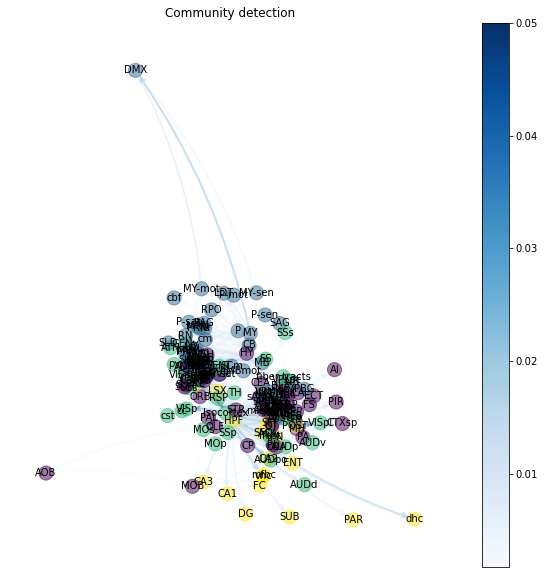

In [179]:
from sknetwork.clustering import Louvain, modularity, bimodularity
import matplotlib.cm as cm

plt.figure(figsize=(10,10))

louvain = Louvain()
labels = louvain.fit_transform(nx.adjacency_matrix(G))

#copy of pieter's prototype code
pos = nx.kamada_kawai_layout(G) # nx.spring_layout(G)

# nodes
cmap = cm.get_cmap('viridis', max(labels) + 1)
nx.draw_networkx_nodes(G, pos,  node_size=200,
                       cmap=cmap, alpha=0.5,node_color=labels)
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

edges=nx.draw_networkx_edges(G, pos, node_size=200, edgelist=enonzero,
                             arrowstyle='->', arrowsize=10, width=2,
                               connectionstyle='arc3, rad=0.1',
                             edge_color=weights, edge_cmap=plt.cm.Blues)

for i in range(len(edges)):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(weights)
plt.colorbar(pc)

plt.title('Community detection')
ax = plt.gca()
ax.set_axis_off()
plt.savefig("figures/all_4.svg")
plt.show()

In [45]:
import infomap

In [46]:
import matplotlib.colors as colors

In [47]:
def findCommunities(G):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id and return number of communities found.
    """
    infomapX = infomap.Infomap("--two-level")

    print("Building Infomap network from a NetworkX graph...")
    for e in G.edges():
        infomapX.addLink(*e)

    print("Find communities with Infomap...")
    infomapX.run();

  #  print("Found {} modules with codelength: {}".format(infomapX.numTopModules(), infomapX.codelength()))

    communities = {}
    for node in infomapX.iterLeafNodes():
        communities[node.physicalId] = node.moduleIndex()

    nx.set_node_attributes(G, values=communities, name='community')

In [48]:
def drawNetwork(G):
    # position map
    pos = nx.spring_layout(G)
    # community ids
    communities = [v for k,v in nx.get_node_attributes(G, 'community').items()]
    numCommunities = max(communities) + 1
    print("Number of communities detected is:")
    print(numCommunities)
    # color map from http://colorbrewer2.org/
    cmapLight = colors.ListedColormap(['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6'], 'indexed', numCommunities)
    cmapDark = colors.ListedColormap(['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a'], 'indexed', numCommunities)

    # Draw edges
    nx.draw_networkx_edges(G, pos)

    # Draw nodes
    nodeCollection = nx.draw_networkx_nodes(G,
        pos = pos,
        node_color = communities,
        cmap = cmapLight
    )
    # Set node border color to the darker shade
    darkColors = [cmapDark(v) for v in communities]
    nodeCollection.set_edgecolor(darkColors)

    # Draw node labels
    for n in G.nodes():
        plt.annotate(n,
            xy = pos[n],
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'center',
            xytext = [0, 0],
            color = cmapDark(communities[n])
        )

    plt.axis('off')
    # plt.savefig("karate.png")
    plt.show()

Filtered Dictionary : 
{'MOp': 985, 'SSp': 322, 'SSs': 378, 'VISp': 385, 'ACA': 31, 'PL': 972, 'ORB': 714, 'AI': 95, 'OLF': 698, 'PIR': 961, 'CA1': 382, 'CA3': 463, 'DG': 726, 'ENT': 909, 'LA': 131, 'BLA': 295, 'CP': 672, 'ACB': 56, 'CEA': 536, 'GPe': 1022, 'BST': 351, 'TH': 549, 'VPM': 733, 'MH': 483, 'LH': 186, 'HY': 1097, 'VTA': 749, 'CB': 512}
Building Infomap network from a NetworkX graph...
Find communities with Infomap...
  Infomap v1.3.0 starts at 2022-02-05 17:14:05
  -> Input network: 
  -> No file output!
  -> Configuration: two-level
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node flow: 1, sum link flow: 1
Build internal network with 28 nodes and 680 links...
Calculating one-level codelength... done!
 -> One-level codelength: 4.80058668
Calculating entropy rate... done!
  -> Entropy rate: 4.600748844

Trial 1/1 starting at 2022-02-05

IndexError: list index out of range

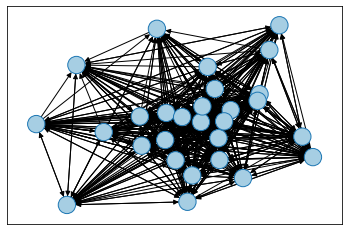

In [49]:
select_acronyms = dict()
# Iterate over all the items in dictionary and filter items which has desired keys
for (key, value) in id_acronym.items():
   # Check if key is even then add pair to new dictionary
   for node in node_input: 
        if key == node:
            select_acronyms[key] = value
print('Filtered Dictionary : ')
print(select_acronyms)

mapping =select_acronyms
H = nx.relabel_nodes(G, mapping)
sorted(H)


findCommunities(H)

drawNetwork(H)

In [ ]:
nx.get_node_attributes(H, 'community')